# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

!pip install imageio
!pip install progressbar

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pylab as plt
import time
import torch
import os

In [3]:
import progressbar as pb

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
agents_number = num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_dim = action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_dim = state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
import time
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        time.sleep(0.1)
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0


actions = [right_to_left, right_jump(threshold>0.5), left_to_right, left_to_jump]

When finished, you can close the environment.

env.close()

### Here's my result

In [125]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

from collections import deque, namedtuple
from typing import Dict, List, Union,Tuple

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [126]:
def hidden_init(layer: nn.Module):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

def layer_init(layer: nn.Module, range_value: Tuple[float, float]):
    layer.weight.data.uniform_(*range_value)

class ActorBody(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64]):
        super(ActorBody, self).__init__()

        num_layers = [input_dim] + list(hidden_layers) + [output_dim]
        layers = [ nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(num_layers[:-1], num_layers[1:]) ]

        self.layers = nn.ModuleList(layers)
        self.reset_parameters()

        self.gate = F.relu
        self.gate_out = torch.tanh

    def reset_parameters(self):
        for layer in self.layers:
            layer.weight.data.uniform_(*hidden_init(layer))
        layer_init(self.layers[-1], (-3e-3, 3e-3))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.gate(layer(x))
        return self.gate_out(self.layers[-1](x))

class CriticBody(nn.Module):
    def __init__(self, input_dim: int, action_dim: int, hidden_layers=[64,64]):
        super(CriticBody, self).__init__()

        num_layers = [input_dim+action_dim] + list(hidden_layers) + [1]
        layers = [nn.Linear(in_dim, out_dim) for in_dim, out_dim in zip(num_layers[:-1], num_layers[1:])]
        self.layers = nn.ModuleList(layers)
        self.bn = nn.BatchNorm1d(num_layers[1])

        self.gate = F.leaky_relu
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.weight.data.uniform_(*hidden_init(layer))
        layer_init(self.layers[-1], (-3e-3, 3e-3))

    def forward(self, x, actions):
        # critic network simply outputs a number
        for idx, layer in enumerate(self.layers[:-1]):
            if idx == 0:
                x = self.gate(layer(torch.cat((x, actions), dim=1)))
                x = self.bn(x)
            else:
                x = self.gate(layer(x))
        return self.layers[-1](x)


In [127]:
class ReplayBuffer():

    def __init__(self, batch_size, buffer_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        """Append an experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """Sample experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the length of the memory"""
        return len(self.memory)


In [128]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, agents=2, hidden_layers=(128, 128), actor_lr=1e-3, actor_lr_decay=0, critic_lr=2e-3, critic_lr_decay=0, noise_scale=0.2, noise_sigma=0.1, clip=(-1, 1), device=None):
        super(DDPGAgent, self).__init__()
        self.device = device if device is not None else DEVICE

        self.actor = ActorBody(agents*state_dim, action_dim, hidden_layers=hidden_layers).to(self.device)
        self.critic = CriticBody(agents*state_dim, agents*action_dim, hidden_layers=hidden_layers).to(self.device)
        self.target_actor = ActorBody(agents*state_dim, action_dim, hidden_layers=hidden_layers).to(self.device)
        self.target_critic = CriticBody(agents*state_dim, agents*action_dim,  hidden_layers=hidden_layers).to(self.device)

        noise_theta = 0.15
        #self.noise = OUNoise((action_dim), scale=noise_scale, theta=noise_theta, sigma=noise_sigma, device=self.device)
        self.noise = GaussianNoise(dim=(action_dim,), mu=1e-8, sigma=noise_sigma, scale=noise_scale, device=device)

        # initialize targets same as original networks
        self.hard_update(self.target_actor, self.actor)
        self.hard_update(self.target_critic, self.critic)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr, weight_decay=actor_lr_decay)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr, weight_decay=critic_lr_decay)
        self.action_min = clip[0]
        self.action_max = clip[1]
    
    def reset_noise(self):
        self.noise.reset_states()

    def reset_agent(self):
        self.actor.reset_parameters()
        self.critic.reset_parameters()
        self.target_actor.reset_parameters()
        self.target_critic.reset_parameters()

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def act(self, obs, noise: float=0.0):
        obs = obs.to(self.device)
        action = self.actor(obs) + noise*self.noise.sample()
        return torch.clamp(action, self.action_min, self.action_max)

    def target_act(self, obs, noise: float=0.0):
        obs = obs.to(self.device)
        action = self.target_actor(obs) + noise*self.noise.sample()
        return torch.clamp(action, self.action_min, self.action_max)

class GaussianNoise:
    def __init__(self, dim, mu=0, sigma=1, scale=1, device=None):
        self.dim = dim
        self.mu = mu
        self.sigma = sigma
        self.scale = scale
        self.device = device if device is not None else DEVICE

    def reset_states(self):
        pass

    def sample(self):
        return torch.tensor(self.scale*np.random.normal(self.mu, self.sigma, self.dim)).to(self.device)

In [209]:
class MADDPG:
    def __init__(self, env, state_dim: int, action_dim: int, config: Dict, device=None, writer=None):
        self.logger = logging.getLogger("MADDPG")
        self.device = device if device is not None else DEVICE
        self.writer = writer

        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.agents_number = config['agents_number']

        hidden_layers = config.get('hidden_layers', (400, 300))
        noise_scale = config.get('noise_scale', 0.2)
        noise_sigma = config.get('noise_sigma', 0.1)
        actor_lr = config.get('actor_lr', 1e-3)
        actor_lr_decay = config.get('actor_lr_decay', 0)
        critic_lr = config.get('critic_lr', 1e-3)
        critic_lr_decay = config.get('critic_lr_decay', 0)
        self.actor_tau = config.get('actor_tau', 0.002)
        self.critic_tau = config.get('critic_tau', 0.002)
        create_agent = lambda: DDPGAgent(
                                    state_dim, action_dim, agents=self.agents_number,
                                    hidden_layers=hidden_layers, actor_lr=actor_lr, actor_lr_decay=actor_lr_decay, critic_lr=critic_lr, critic_lr_decay=critic_lr_decay,
                                    noise_scale=noise_scale, noise_sigma=noise_sigma,
                                    device=self.device)
        self.maddpg_agent = [create_agent() for _ in range(self.agents_number)]
        
        self.discount = 0.99 if 'discount' not in config else config['discount']
        self.gradient_clip = 2.0 if 'gradient_clip' not in config else config['gradient_clip']

        self.warm_up = 1e3 if 'warm_up' not in config else config['warm_up']
        self.buffer_size = int(1e6) if 'buffer_size' not in config else config['buffer_size']
        self.batch_size = config.get('batch_size', 128)
        self.p_batch_size = config.get('p_batch_size', int(self.batch_size // 2))
        self.n_batch_size = config.get('n_batch_size', int(self.batch_size // 4))
        self.buffer = ReplayBuffer(self.batch_size, self.buffer_size)
        # self.buffer = DirectedReplayBuffer(self.batch_size, self.buffer_size, p_batch_size=self.p_batch_size, n_batch_size=self.n_batch_size, device=self.device)

        self.update_every_iterations = config.get('update_every_iterations', 2)
        self.number_updates = config.get('number_updates', 2)
        
        self.soft_update_count = 0
        self.soft_update_every = config.get('soft_update_every', 4)

        self.reset()

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def reset(self):
        self.iteration = 0
        self.reset_agents()
        self.reset_noise()

    def reset_agents(self):
        for agent in self.maddpg_agent:
            agent.reset_agent()
    
    def reset_noise(self):
        for agent in self.maddpg_agent:
            agent.reset_noise()

    def step(self, state, action, reward, next_state, done) -> None:
        if np.isnan(state).any() or np.isnan(next_state).any():
            print("State contains NaN. Skipping.")
            return

        self.iteration += 1
        self.buffer.add(state, action, reward, next_state, done)

        if self.iteration < self.warm_up:
            return

        if len(self.buffer) > self.batch_size and (self.iteration % self.update_every_iterations) == 0:
            self.evok_learning()

    def filter_batch(self, batch, agent_number):
        states, actions, rewards, next_states, dones = batch
        agent_states = states[:, agent_number*self.state_dim:(agent_number+1)*self.state_dim].detach().clone()
        agent_next_states = next_states[:, agent_number*self.state_dim:(agent_number+1)*self.state_dim].detach().clone()
        agent_rewards = rewards.select(1, agent_number).view(-1, 1).detach().clone()
        agent_dones = dones.select(1, agent_number).view(-1, 1).detach().clone()
        return (agent_states, states, actions, agent_rewards, agent_next_states, next_states, agent_dones)

    def evok_learning(self):
        for _ in range(self.number_updates):
            for agent_number in range(self.agents_number):
                batch = self.filter_batch(self.buffer.sample(), agent_number)
                self.learn(batch, agent_number)
                # self.update_targets()

    def act(self, states, noise: Union[None, List]=None):
        """get actions from all agents in the MADDPG object"""

        noise = [0]*self.agents_number if noise is None else noise
        states = torch.from_numpy(states).float().to(device)

        # tensor_states = torch.tensor(states).view(-1, self.agents_number, self.state_dim)

        with torch.no_grad():
            actions = []
            for agent_number, agent in enumerate(self.maddpg_agent):
                agent.actor.eval()
                # actions += agent.act(tensor_states.select(1, agent_number), noise[agent_number])
                actions += agent.act(states, noise[agent_number])
                agent.actor.train()

        return torch.stack(actions)

    def learn(self, samples, agent_number: int) -> None:
        """update the critics and actors of all the agents """

        action_offset = agent_number*self.action_dim
        flatten_actions = lambda a: a.view(-1, self.agents_number*self.action_dim)

        # No need to flip since there are no paralle agents
        agent_states, states, actions, rewards, agent_next_states, next_states, dones = samples

        agent = self.maddpg_agent[agent_number]

        next_actions = actions.clone()
        next_actions[:, action_offset:action_offset+self.action_dim] = agent.target_actor(next_states)

        #next_actions = agent.target_actor(next_states)
        #if agent_number == 0:
        #    next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
        #else:
        #    next_actions = torch.cat((actions[:,:2], next_actions), dim=1)
        
        
        # critic loss
        #Q_target_next = agent.target_critic(next_states, flatten_actions(next_actions))
        Q_target_next = agent.target_critic(next_states, next_actions)
        Q_target = rewards + (self.discount * Q_target_next * (1 - dones))
        Q_expected = agent.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_target)
        # critic_loss = F.mse_loss(Q_expected, Q_target)

        
        # Minimize the loss
        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), self.gradient_clip)
        agent.critic_optimizer.step()

        # Compute actor loss
        pred_actions = actions.clone()
        # pred_actions.data[:, action_offset:action_offset+self.action_dim] = agent.actor(agent_states)
        pred_actions[:, action_offset:action_offset+self.action_dim] = agent.actor(states)

        # Compute actor loss
        #pred_actions = agent.actor(states)
        #if agent_number == 0:
        #    pred_actions = torch.cat((pred_actions, actions[:,2:]), dim=1)
        #else:
        #    pred_actions = torch.cat((actions[:,:2], pred_actions), dim=1)
        
        
        actor_loss = -agent.critic(states, pred_actions).mean()
        #actor_loss = -agent.critic(states, flatten_actions(pred_actions)).mean()
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.actor_loss.parameters(), self.gradient_clip)
        agent.actor_optimizer.step()

        if self.writer:
            self.writer.add_scalar(f'agent{agent_number}/critic_loss', critic_loss.item(), self.iteration)
            self.writer.add_scalar(f'agent{agent_number}/actor_loss', abs(actor_loss.item()), self.iteration)
        
        self.soft_update_count += 1
        if (self.soft_update_count % self.soft_update_every) == 0:
            self._soft_update(agent.target_actor, agent.actor, self.actor_tau)
            self._soft_update(agent.target_critic, agent.critic, self.critic_tau)

    def update_targets(self):
        """soft update targets"""
        for ddpg_agent in self.maddpg_agent:
            self._soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.actor_tau)
            self._soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.critic_tau)

    def _soft_update(self, target: nn.Module, source: nn.Module, tau) -> None:
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


In [199]:
states, actions, rewards, next_states, dones  = maddpg.buffer.sample()

In [200]:
actions

tensor([[-0.0328,  0.0347, -0.0561, -0.0771],
        [-0.0297,  0.0417, -0.0586, -0.0790],
        [-0.0317,  0.0407, -0.0645, -0.0809],
        ...,
        [-0.0252,  0.0348, -0.0526, -0.0778],
        [-0.0339,  0.0432, -0.0572, -0.0775],
        [-0.0352,  0.0332, -0.0547, -0.0778]], device='cuda:0')

In [204]:
pred_actions = actions.detach().clone()

In [206]:
pred_actions[:, 0:2] = maddpg.maddpg_agent[0].actor(states)

In [207]:
pred_actions

tensor([[-0.0328,  0.0347, -0.0561, -0.0771],
        [-0.0297,  0.0417, -0.0586, -0.0790],
        [-0.0317,  0.0407, -0.0645, -0.0809],
        ...,
        [-0.0252,  0.0348, -0.0526, -0.0778],
        [-0.0339,  0.0432, -0.0572, -0.0775],
        [-0.0352,  0.0332, -0.0547, -0.0778]], device='cuda:0',
       grad_fn=<CopySlices>)

In [208]:
torch.cat((actions[:, 0:2], maddpg.maddpg_agent[0].actor(states)), dim=1)

tensor([[-0.0328,  0.0347, -0.0328,  0.0347],
        [-0.0297,  0.0417, -0.0297,  0.0417],
        [-0.0317,  0.0407, -0.0317,  0.0407],
        ...,
        [-0.0252,  0.0348, -0.0252,  0.0348],
        [-0.0339,  0.0432, -0.0339,  0.0432],
        [-0.0352,  0.0332, -0.0352,  0.0332]], device='cuda:0',
       grad_fn=<CatBackward>)

In [189]:
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


os.makedirs("./model_results", exist_ok=True)

In [190]:
def moving_average(a, n=100) :
    ret = np.cumsum(np.concatenate([np.zeros(n), a]))
    ret[n:] = ret[n:] - ret[:-n]
    n_arr = np.clip(np.arange(1, len(a)+1), 1, n)
    return ret[n:] / n_arr

In [191]:
def noise_injection(r, r0=0.05, n_max=1., n_min=0.01):
    if r <= 0: return n_max
    return np.clip(r0/np.sqrt(r), n_min, n_max)

In [192]:
class Task:
    def __init__(self, env, brain_name):
        self.env = env
        self.brain_name = brain_name
        self.reset()
        
        uniform = torch.distributions.Uniform(-1, 1)
        uniform._batch_shape = torch.Size([1, env.brains[brain_name].vector_action_space_size])
        
        self.action_space = uniform
        
    def reset(self, train_mode=True):
        out = self.env.reset(train_mode=train_mode)[brain_name]     # reset the environment
        return out.vector_observations
    
    def step(self, action):
        out = env.step(action)[self.brain_name]
        state = out.vector_observations
        rewards = out.rewards
        done = out.local_done
        info = out.text_observations
        return (state, rewards, done, info)

In [193]:
task = Task(env, brain_name)
device = torch.device('cuda')

In [194]:
from torch.utils.tensorboard import SummaryWriter

In [195]:
def seeding(seed=32167):
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)

seeding()

In [196]:
writer = SummaryWriter('runs/p3_maddpg_117')

number_of_episodes = 500
max_episode_length = 200
warmup_episodes = 20000000

noise = 1.0
noise_max, noise_min = 1., 0.1
noise_reduction = 0.9999
noise_reset_episodes = 1000

episode_score_every = 50
save_interval = 200

config = {'batch_size': 512,
          'p_batch_size': 3,
          'n_batch_size': 3,
          'buffer_size': int(1e5),
          'number_updates': 1,
          'update_every_iterations': 1,
          'soft_update_every': 4,
          'critic_lr': 1e-3,
          'actor_lr': 1e-3,
          'actor_lr_decay': 0,
          'critic_lr_decay': 0,
          'actor_tau': 0.008,
          'critic_tau': 0.008,
          'warm_up': 0,
          'hidden_layers': (256, 128),
          'noise_scale': 1.,
          'noise_sigma': .4,
          'agents_number': agents_number,
          'gradient_clip': 1.0,
          'discount': 0.99,
         }

maddpg = MADDPG(task, state_dim, action_dim, config, device, writer)
maddpg.reset()

all_rewards = np.zeros((number_of_episodes, agents_number))

In [197]:
print(maddpg.maddpg_agent[0].actor)
print(maddpg.maddpg_agent[0].critic)

ActorBody(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
CriticBody(
  (layers): ModuleList(
    (0): Linear(in_features=52, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


<timed exec>:37: RuntimeWarning: Mean of empty slice.                        | 
/home/kretyn/courses/DeRL/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep   49. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep   99. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  149. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  199. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  249. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  299. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  349. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  399. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  449. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0


Ep  499. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise:    0.0
CPU times: user 2min 37s, sys: 2 s, total: 2min 39s
Wall time: 2min 46s


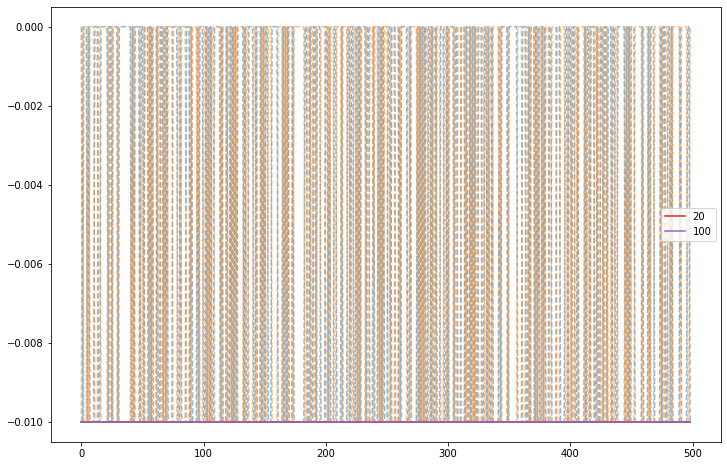

In [198]:
%%time
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()
task.reset()

noise = 0.0
noise_min = 0.0
noise_reduction = 0.0
noise_arr = [noise]*agents_number

for episode in range(number_of_episodes):
    timer.update(episode)
    
    state = task.reset().flatten()
    episode_reward = np.zeros(num_agents)

    for frame_idx in range(max_episode_length):

        actions = maddpg.act(state, noise=noise_arr)
        actions = actions.detach().cpu().numpy().flatten()

        next_state, rewards, dones, info = task.step(actions)

        episode_reward += rewards
        next_state = next_state.flatten()
        maddpg.step(state, actions, list(rewards), next_state, dones)

        state = next_state.copy()
        
        if any(dones):
            break

    all_rewards[episode] = episode_reward
    _r = all_rewards[max(episode-100, 0):episode]
    metrics_rewards = {'agent0': episode_reward[0], 'agent1': episode_reward[1]}
    metrics_avg10 = {'game': _r.max(axis=1).mean(), 'agent0': _r[:,0].mean(), 'agent1': _r[:,1].mean()}
    writer.add_scalars('rewards/avg100', metrics_avg10, episode)
    writer.add_scalars('rewards/rewards', metrics_rewards, episode)

    #noise_arr = [noise_injection(all_rewards[max(episode-5, 0):episode, agent].mean(), r0=max(0, 0.005-0.005*(episode/100)), n_max=noise_max, n_min=noise_min) for agent in range(agents_number)]
    #noise = max(noise*noise_reduction, noise_min)
    #noise = noise if noise > 0.6 else 0.1
    #noise_arr = [noise]*agents_number
    
    maddpg.reset_noise()
    
    if (episode > warmup_episodes):
        maddpg.evok_learning()
    
    if (episode % episode_score_every) == (episode_score_every-1) or episode == number_of_episodes-1:
        print(f'Ep {episode:4}. Rewards (over last 100): Avg: {np.max(_r, axis=1).mean():<7.3} | Max: {np.max(_r):<4.2} | Min: {np.min(_r):4.2} | Noise: {noise:6.3}')
        
    if episode > 5000 and (episode % 50 == 0) and np.max(all_rewards[episode-300:episode+1],axis=1).sum() <= 0.01:
        print("This is pointless. Breaking.")
        break

    #saving model
    if all_rewards[-10:].max() > 0.5:
        save_dict_list = []
        for agent_i in range(agents_number):
            save_dict = {
                'actor_params' : maddpg.maddpg_agent[agent_i].actor.state_dict(),
                'actor_optim_params': maddpg.maddpg_agent[agent_i].actor_optimizer.state_dict(),
                'critic_params' : maddpg.maddpg_agent[agent_i].critic.state_dict(),
                'critic_optim_params' : maddpg.maddpg_agent[agent_i].critic_optimizer.state_dict()
            }
            save_dict_list.append(save_dict)

        torch.save(save_dict_list, f"./model_results/episode-{episode}.pt")
        
        if all_rewards[-10:].max() > 0.5:
            print("Obtained the required value")
            break

timer.finish()

plt.figure(figsize=(12,8))
all_rewards_total = np.sum(all_rewards, axis=1)
plt.plot(all_rewards[:episode], '--', alpha=0.5)
plt.plot(all_rewards_total[:episode], alpha=0.5)
plt.plot(moving_average(all_rewards_total[:episode], 20), label='20')
plt.plot(moving_average(all_rewards_total[:episode]), label='100')
plt.legend()

Text(0.5, 0.98, 'Total num actions 22368')

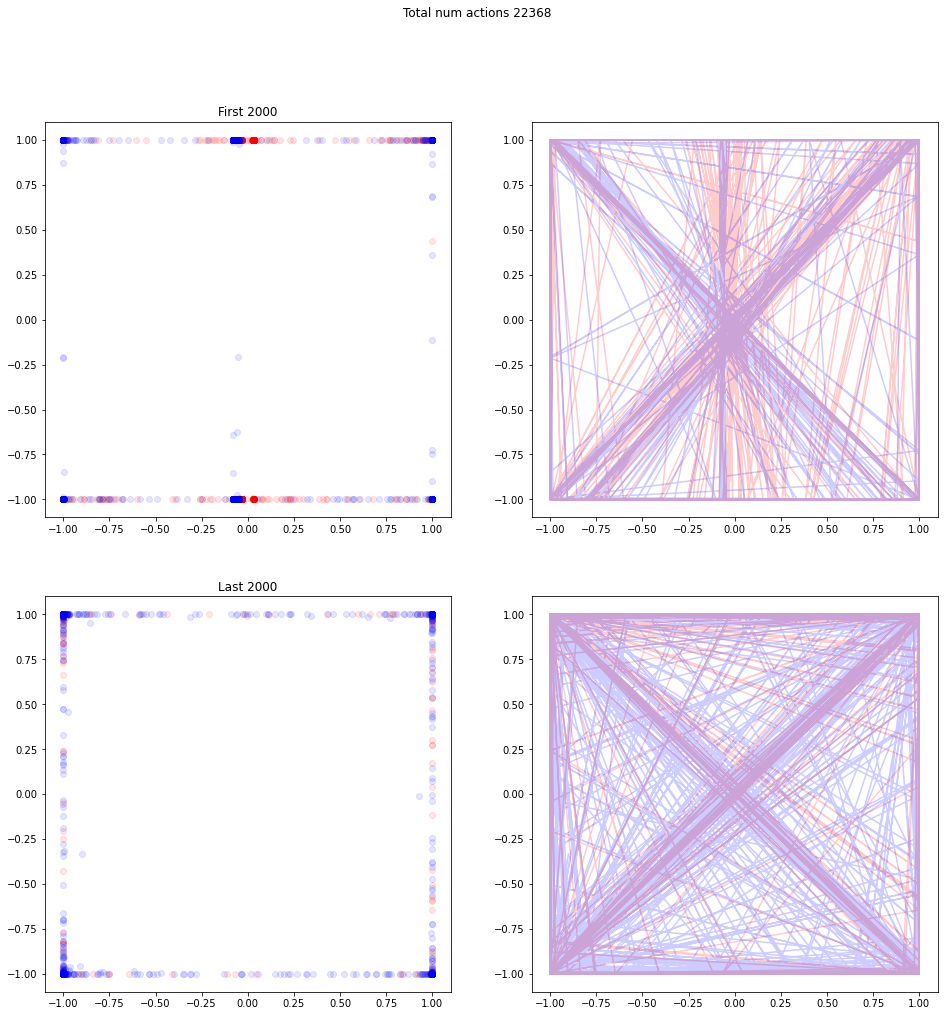

In [151]:
samples = maddpg.buffer.memory
all_actions = np.array([s[1] for s in samples])


fig, axes = plt.subplots(2,2, figsize=(16, 16))

actions = all_actions[:2000]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump

ax = axes[0][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("First 2000")

ax = axes[0][1]
ax.plot(-x1, y1, color='r', alpha=0.2)
ax.plot(x2, y2, color='b', alpha=0.2)

actions = all_actions[-2000:]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump
ax = axes[1][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("Last 2000")

ax = axes[1][1]
ax.plot(-x1, y1, color='r', alpha=0.2)
ax.plot(x2, y2, color='b', alpha=0.2)


plt.suptitle(f"Total num actions {len(all_actions)}")

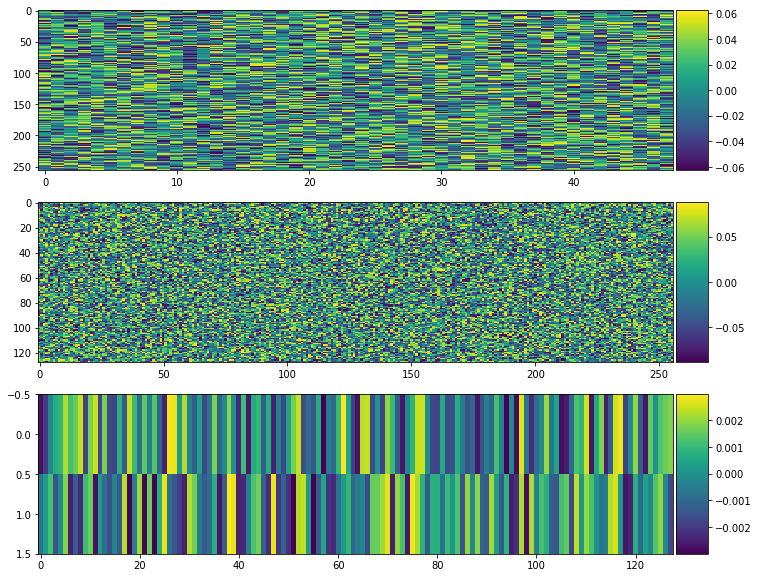

In [24]:
layers = maddpg.maddpg_agent[0].actor.layers
fig, axes = plt.subplots(len(layers), 1, figsize=(12,10))
for idx, layer in enumerate(layers):
    ax = axes[idx]
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

    fig.colorbar(im, cax=cax, orientation='vertical')

# Debug

In [25]:
raise

RuntimeError: No active exception to reraise

# Testing model

In [ ]:
batch = maddpg.buffer.sample()

In [ ]:
rewards = batch[2]

In [ ]:
sum(rewards[:,0] < 0)

In [ ]:
import time
_noise = 0.2
for i in range(1, 5):
    states = task.reset(train_mode=False)
    scores = np.zeros(num_agents)
    while True:
        time.sleep(0.05)
        actions = maddpg.act(np.array(states, dtype=np.float32).flatten(), _noise)
        #print(actions.cpu().numpy().flatten())
        next_states, rewards, dones, info = task.step(actions.cpu().numpy().flatten())
        print(rewards)
        scores += rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

# Development is here

In [ ]:
a = np.arange(4).reshape((2,2))

In [ ]:
torch.stack([torch.tensor(_) for _ in a])

In [ ]:
torch.stack([torch.tensor(_) for _ in a]).T

In [ ]:
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda')
agent_number = agent_no = 0

In [ ]:
self = maddpg

In [ ]:
samples = maddpg.filter_batch(maddpg.buffer.sample(), agent_number)
print(f"agent_states: {samples[0].shape}")
print(f"state: {samples[1].shape}")
print(f"actions: {samples[2].shape}")
print(f"rewards: {samples[3].shape}")
print(f"agent_next_states: {samples[4].shape}")
print(f"next_states: {samples[5].shape}")
print(f"dones: {samples[6].shape}")

In [ ]:
action_offset = agent_number*self.action_dim
flatten_actions = lambda a: a.view(-1, self.agents_number*self.action_dim)

# No need to flip since there are no paralle agents
agent_states, states, actions, rewards, agent_next_states, next_states, dones = samples

agent = self.maddpg_agent[agent_number]

next_actions = actions.detach().clone()
next_actions.data[:, action_offset:action_offset+self.action_dim] = agent.target_actor(agent_next_states)

# critic loss
Q_target_next = agent.target_critic(next_states, flatten_actions(next_actions))
Q_target = rewards + (self.discount * Q_target_next * (1 - dones))
Q_expected = agent.critic(states, actions)
critic_loss = F.mse_loss(Q_expected, Q_target)

# Minimize the loss
agent.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), self.gradient_clip)
agent.critic_optimizer.step()

# Compute actor loss
pred_actions = actions.detach().clone()
pred_actions.data[:, action_offset:action_offset+self.action_dim] = agent.actor(agent_states)

actor_loss = -agent.critic(states, flatten_actions(pred_actions)).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()

if self.writter:
    self.writter.add_scalar(f'critic_loss_a{agent_number}', critic_loss.item(), self.iteration)
    self.writter.add_scalar(f'actor_loss_a{agent_number}', actor_loss.item(), self.iteration)

self._soft_update(agent.target_actor, agent.actor)
self._soft_update(agent.target_critic, agent.critic)

In [ ]:
if torch.isnan(agent_states).any():
    print("Yes")

In [ ]:
states[:10,0]

In [ ]:
actor_loss = -agent.critic(states, flatten_actions(pred_actions)).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()

In [ ]:
actor_loss.item()

In [ ]:
x, y = actions.reshape(2, -1)

In [ ]:
_tmp = (1- agent_dones)*self.discount*Q_target_next
print(_tmp.shape)

In [ ]:
print(f"state.shape: {state.shape}")
print(f"q_input.shape: {q_input.shape}")
print(f"q_input2.shape: {q_input2.shape}")
print(f"action.shape: {action.shape}")

In [ ]:
states, actions, rewards, next_states, dones = batch

agent = self.maddpg_agent[agent_no]
next_actions = agent.target_actor(next_states)

if agent_no == 0:
    next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
else:
    next_actions = torch.cat((actions[:,:2], next_actions), dim=1)

# Compute critic loss
Q_expected = agent.critic(states, actions)
Q_target_next = agent.target_critic(next_states, next_actions)
Q_target = rewards + (self.discount * Q_target_next * (1 - dones))
critic_loss = F.mse_loss(Q_expected, Q_target)

# Minimize the loss
agent.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm_(agent.local_critic.parameters(), 1)
agent.critic_optimizer.step()

# Compute actor loss
actions_pred = agent.actor(states)
if agent_no == 0:
    actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
else:
    actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

actor_loss = agent.critic(states, actions_pred).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()


# Stealing

In [52]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import copy
import random

from unityagents import UnityEnvironment
from collections import namedtuple, deque
%matplotlib inline

In [53]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build a network that maps state -> action values"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(2 * (state_size + action_size), fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a network that maps (state, action) -> Q values"""
        x = F.leaky_relu(self.fc1(torch.cat((state, action.float()), dim=1)))
        x = self.bn(x)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [54]:
class ReplayBuffer():
    """Buffer to replay experience tuples"""
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize ReplayBuffer class
        
        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Length of replay buffer
            batch_size (int): Size of each training mini-batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add_experience(self, state, action, reward, next_state, done):
        """Append an experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """Sample experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the length of the memory"""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck noise process to be added to the actions."""

    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [55]:
class MADDPG_Agent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=512, update_every=4, 
                 no_agents=2, alpha=.001, beta=.001, gamma=.99, tau=.008, epsilon=0.99):
        """ Initialize agent attributes
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            buffer_size (int): Size of replay buffer
            batch_size (int): Batch size for replay buffer
            no_agents (int): Number of agents
            alpha (float): Learning rate for actor
            beta (float): Learning rate for critic
            tau (float): Soft update multiplier
            epsilon (float): Parameter for controlling exploration vs exploitation via OU noise
        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.no_agents = no_agents
        
        self.local_actor = Actor(state_size, action_size).to(device)
        self.target_actor = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.local_actor.parameters(), lr=alpha)
        
        self.local_critic = Critic(state_size, action_size).to(device)
        self.target_critic = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.local_critic.parameters(), lr=beta)
        
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.noise = OUNoise((no_agents, action_size))
        self.timesteps = 0
        
    def step(self, state, action, reward, next_state, done, agent_no):
        """Save experience in replay buffer, use random sample from buffer to learn
        Params
        ======
            state (ndarray): State of the environment
            action (ndarray): Action chosen by the agent
            reward (ndarray): Reward given by the environment
            next_state (ndarray): Next state of the environment
            done (ndarray): Flag to indicate if the episode is finished after this action
            agent_no (int): Which agent (1 or 2) performs the step
        """
        self.timesteps += 1
        self.memory.add_experience(state, action, reward, next_state, done)
        
        if len(self.memory) >= self.batch_size:
            batch = self.memory.sample()
            self.learn(batch, self.gamma, agent_no)
    
    def act(self, states, add_noise=True):
        """Given a state, choose an action to take
        Params
        ======
            state (ndarray): State of the environment
            score (float): Current score
            add_noise (bool): Flag indicating whether or not to add ou noise to the environment
        """
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.no_agents, self.action_size))
        
        self.local_actor.eval() # Set local network to evaluation mode
        with torch.no_grad():
            for agent_no, state in enumerate(states):
                action = self.local_actor(state).cpu().data.numpy()
                actions[agent_no, :] = action
        self.local_actor.train()
            
        if add_noise:
            actions += self.epsilon * self.noise.sample()
                
        return np.clip(action, -1, 1)
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters
        
        Params
        ======
            local_model (nn.Module): model to copy weights from
            target_model (nn.Module): model to copy weights to
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
    
    def learn(self, batch, gamma, agent_no):
        """ Given a batch of experiences, update the local network and soft update on target networks.
        Q = r + gamma * critic_target(next_state, actor_target(next_state))
        
        Params
        ======
            batch (tuple of tensors): Experiences - (states, actions, rewards, next_states, dones)
            gamma (float): Discount factor for rewards
            agent_no (int): Which agent to update
        """
        states, actions, rewards, next_states, dones = batch
        
        next_actions = self.target_actor(next_states)
        
        if agent_no == 0:
            next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
        else:
            next_actions = torch.cat((actions[:,:2], next_actions), dim=1)

        # Compute critic loss
        Q_expected = self.local_critic(states, actions)
        Q_target_next = self.target_critic(next_states, next_actions)
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        critic_loss = F.mse_loss(Q_expected, Q_target)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_critic.parameters(), 1)
        self.critic_optimizer.step()
        
        # Compute actor loss
        actions_pred = self.local_actor(states)
        if agent_no == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        
        actor_loss = -self.local_critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Reduce exploration
        # self.epsilon *= self.epsilon
        
        # Soft update
        if self.timesteps % self.update_every == 0:
            self.soft_update(self.local_critic, self.target_critic)
            self.soft_update(self.local_actor, self.target_actor)
        
    def reset(self):
        self.epsilon *= self.epsilon
        self.noise.reset()


In [56]:
device = torch.device('cuda')

In [57]:
agent0 = MADDPG_Agent(state_size, action_size)
agent1 = MADDPG_Agent(state_size, action_size)


In [58]:
agent0.local_critic

Critic(
  (fc1): Linear(in_features=52, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [60]:
%%time
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

n_episodes = 4000
current_score = 0
scores = list()
rolling_average = list()
score_deque = deque(maxlen=100)

for episode in range(1, n_episodes+1):
    timer.update(episode)
    
    env_info = env.reset(train_mode=True)[brain_name]
    states = np.reshape(env_info.vector_observations, (1,48))
    agent0.reset()
    agent1.reset()
    episode_scores = np.zeros(len(env_info.agents))
    while True:
        action_0 = agent0.act(states)
        action_1 = agent1.act(states)
        actions = np.concatenate((action_0, action_1), axis=0).flatten()
        
        env_info = env.step(actions)[brain_name]
        
        next_states = np.reshape(env_info.vector_observations, (1, 48))
        rewards = env_info.rewards
        dones = env_info.local_done
        episode_scores += np.max(rewards)
        
        agent0.step(states, actions, rewards[0], next_states, dones[0], 0)
        agent1.step(states, actions, rewards[1], next_states, dones[1], 1)

        states = next_states
        
        if np.any(dones):
            break
            
    episode_score = np.max(episode_scores)
    score_deque.append(episode_score)
    scores.append(episode_score)
    ra_current = np.mean(score_deque)
    rolling_average.append(ra_current)
    if episode == 1 or episode % 100 == 0:
        print("Episode {} complete! Average score: {:.4f}\tEpisode score: {:.4f}".format(episode, ra_current, episode_score))
    
    if ra_current >= 0.5 and len(score_deque) > 99:
        print("Target reward achieved in {} episodes! Average score: {:.4f}".format(episode, ra_current))
        torch.save(agent0.target_actor.state_dict(), 'agent0_actor_solution.pth')
        torch.save(agent0.target_critic.state_dict(), 'agent0_critic_solution.pth')
        torch.save(agent1.target_actor.state_dict(), 'agent1_actor_solution.pth')
        torch.save(agent1.target_critic.state_dict(), 'agent1_critic_solution.pth')
        break

Episode 1 complete! Average score: 0.0000	Episode score: 0.0000


Episode 100 complete! Average score: 0.0100	Episode score: 0.0000


Episode 200 complete! Average score: 0.0230	Episode score: 0.1000


Episode 300 complete! Average score: 0.0239	Episode score: 0.1000


Episode 400 complete! Average score: 0.0100	Episode score: 0.0000


Episode 500 complete! Average score: 0.0760	Episode score: 0.0000


Episode 600 complete! Average score: 0.0970	Episode score: 0.0000


Episode 700 complete! Average score: 0.0920	Episode score: 0.1000


Episode 800 complete! Average score: 0.1030	Episode score: 0.1000


Episode 900 complete! Average score: 0.1100	Episode score: 0.1000


Episode 1000 complete! Average score: 0.0920	Episode score: 0.1000


ValueError: Value out of range

In [ ]:
%%time
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

n_episodes = 500
current_score = 0
scores = list()
rolling_average = list()
score_deque = deque(maxlen=100)

for episode in range(1, n_episodes+1):
    timer.update(episode)
    
    env_info = env.reset(train_mode=True)[brain_name]
    states = np.reshape(env_info.vector_observations, (1,48))
    agent0.reset()
    agent1.reset()
    episode_scores = np.zeros(len(env_info.agents))
    while True:
        action_0 = agent0.act(states)
        action_1 = agent1.act(states)
        actions = np.concatenate((action_0, action_1), axis=0).flatten()
        
        env_info = env.step(actions)[brain_name]
        
        next_states = np.reshape(env_info.vector_observations, (1, 48))
        rewards = env_info.rewards
        dones = env_info.local_done
        episode_scores += np.max(rewards)
        
        agent0.step(states, actions, rewards[0], next_states, dones[0], 0)
        agent1.step(states, actions, rewards[1], next_states, dones[1], 1)

        states = next_states
        
        if np.any(dones):
            break
            
    episode_score = np.max(episode_scores)
    score_deque.append(episode_score)
    scores.append(episode_score)
    ra_current = np.mean(score_deque)
    rolling_average.append(ra_current)
    if episode == 1 or episode % 100 == 0:
        print("Episode {} complete! Average score: {:.4f}\tEpisode score: {:.4f}".format(ep, ra_current, episode_score))
    
    if ra_current >= 0.5 and len(score_deque) > 99:
        print("Target reward achieved in {} episodes! Average score: {:.4f}".format(ep, ra_current))
        torch.save(agent0.target_actor.state_dict(), 'agent0_actor_solution.pth')
        torch.save(agent0.target_critic.state_dict(), 'agent0_critic_solution.pth')
        torch.save(agent1.target_actor.state_dict(), 'agent1_actor_solution.pth')
        torch.save(agent1.target_critic.state_dict(), 'agent1_critic_solution.pth')
        break

In [ ]:
plt.plot(scores)

In [ ]:
plt.plot(rolling_average)